In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/widsdatathon2024-challenge1/sample_submission.csv
/kaggle/input/widsdatathon2024-challenge1/training.csv
/kaggle/input/widsdatathon2024-challenge1/test.csv


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.special import expit as sigmoid 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
import plotly.express as px

In [6]:
train_data = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/training.csv")

In [7]:
test_data = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/test.csv")

# **Exploratory Analysis**

In [8]:
train_data

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12901,674178,White,NaN,OH,436,50,F,32.11,C50411,Malig neoplm of upper-outer quadrant of right ...,...,17.400000,23.600000,0.864706,19.841176,6.300000,6.247059,38.753055,8.068682,21.140731,1
12902,452909,NaN,COMMERCIAL,CA,945,50,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,...,11.243210,7.837037,5.411250,34.700000,3.845679,5.671605,36.469947,6.265266,10.728732,1
12903,357486,NaN,COMMERCIAL,CA,926,61,F,29.24,C50912,Malignant neoplasm of unspecified site of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,1
12904,935417,NaN,NaN,NY,112,37,F,31.00,1749,"Malignant neoplasm of breast (female), unspeci...",...,10.194737,18.642105,14.173684,42.502632,6.392105,1.755263,37.722740,7.879795,27.496367,0


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

In [10]:
train_data.select_dtypes(["O"]).nunique()

patient_race                              5
payer_type                                3
patient_state                            50
patient_gender                            1
breast_cancer_diagnosis_code             50
breast_cancer_diagnosis_desc             50
metastatic_cancer_diagnosis_code         43
metastatic_first_novel_treatment          2
metastatic_first_novel_treatment_type     1
Region                                    4
Division                                  9
dtype: int64

Text(0.5, 1.0, 'Distribution of DiagPeriodL90D')

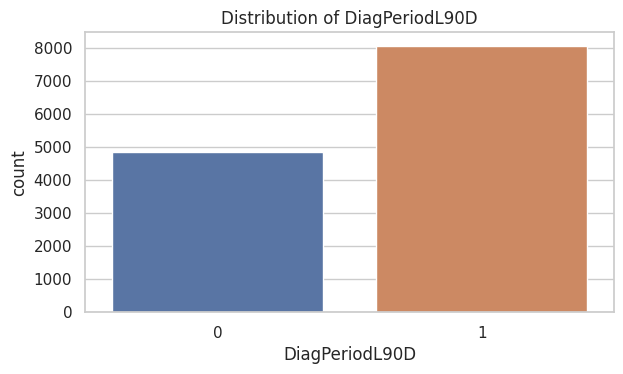

In [11]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
sns.countplot(x='DiagPeriodL90D', data=train_data)
plt.title('Distribution of DiagPeriodL90D')

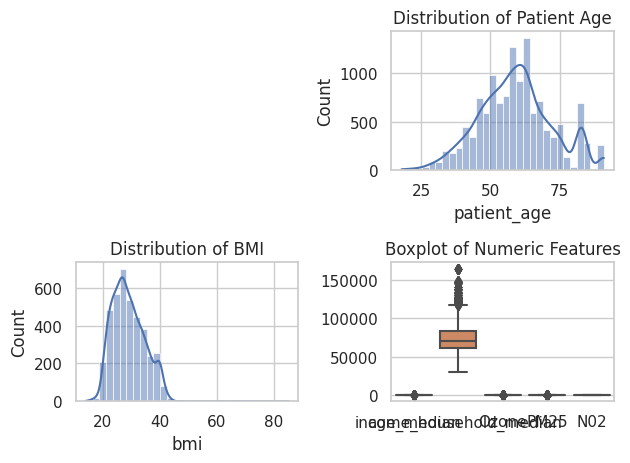

Text(0.5, 1.02, 'Pairplot of Numeric Features')

<Figure size 1500x800 with 0 Axes>

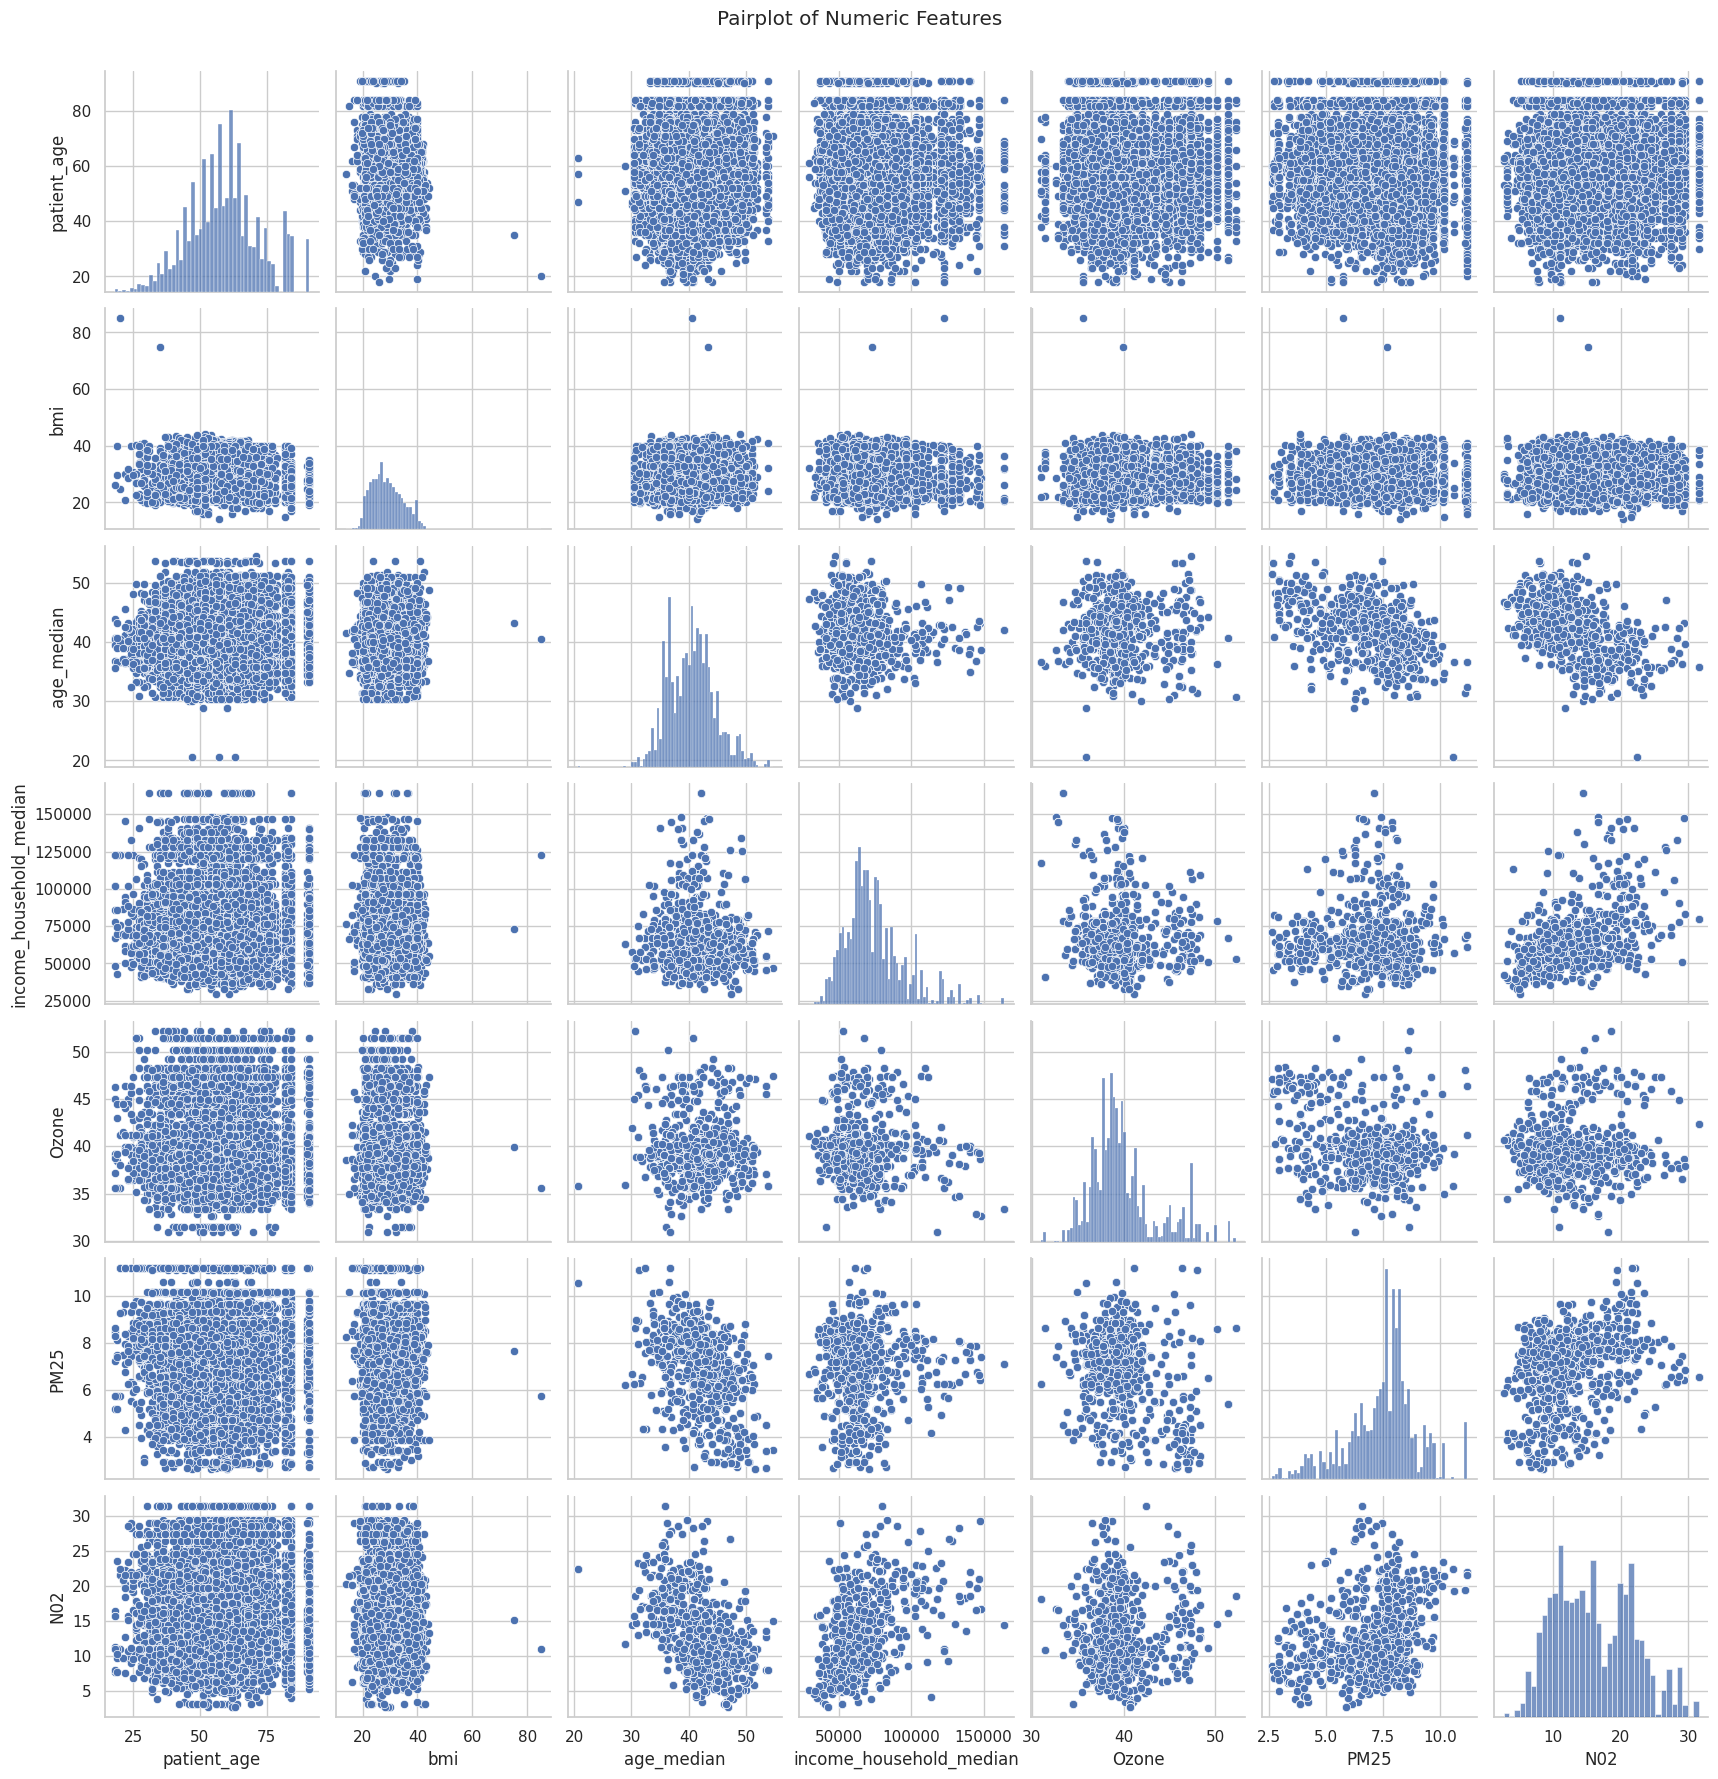

In [12]:
# Age distribution
plt.subplot(2, 2, 2)
sns.histplot(train_data['patient_age'], bins=30, kde=True)
plt.title('Distribution of Patient Age')

# BMI distribution
plt.subplot(2, 2, 3)
sns.histplot(train_data['bmi'].dropna(), bins=30, kde=True)
plt.title('Distribution of BMI')

# Box plot for numeric features
plt.subplot(2, 2, 4)
sns.boxplot(data=train_data[['age_median', 'income_household_median', 'Ozone', 'PM25', 'N02']])
plt.title('Boxplot of Numeric Features')

plt.tight_layout()
plt.show()

# Bivariate Analysis
plt.figure(figsize=(15, 8))

# Pairplot for numeric features
sns.pairplot(train_data[['patient_age', 'bmi', 'age_median', 'income_household_median', 'Ozone', 'PM25', 'N02']])
plt.suptitle('Pairplot of Numeric Features', y=1.02)

<Figure size 640x480 with 0 Axes>

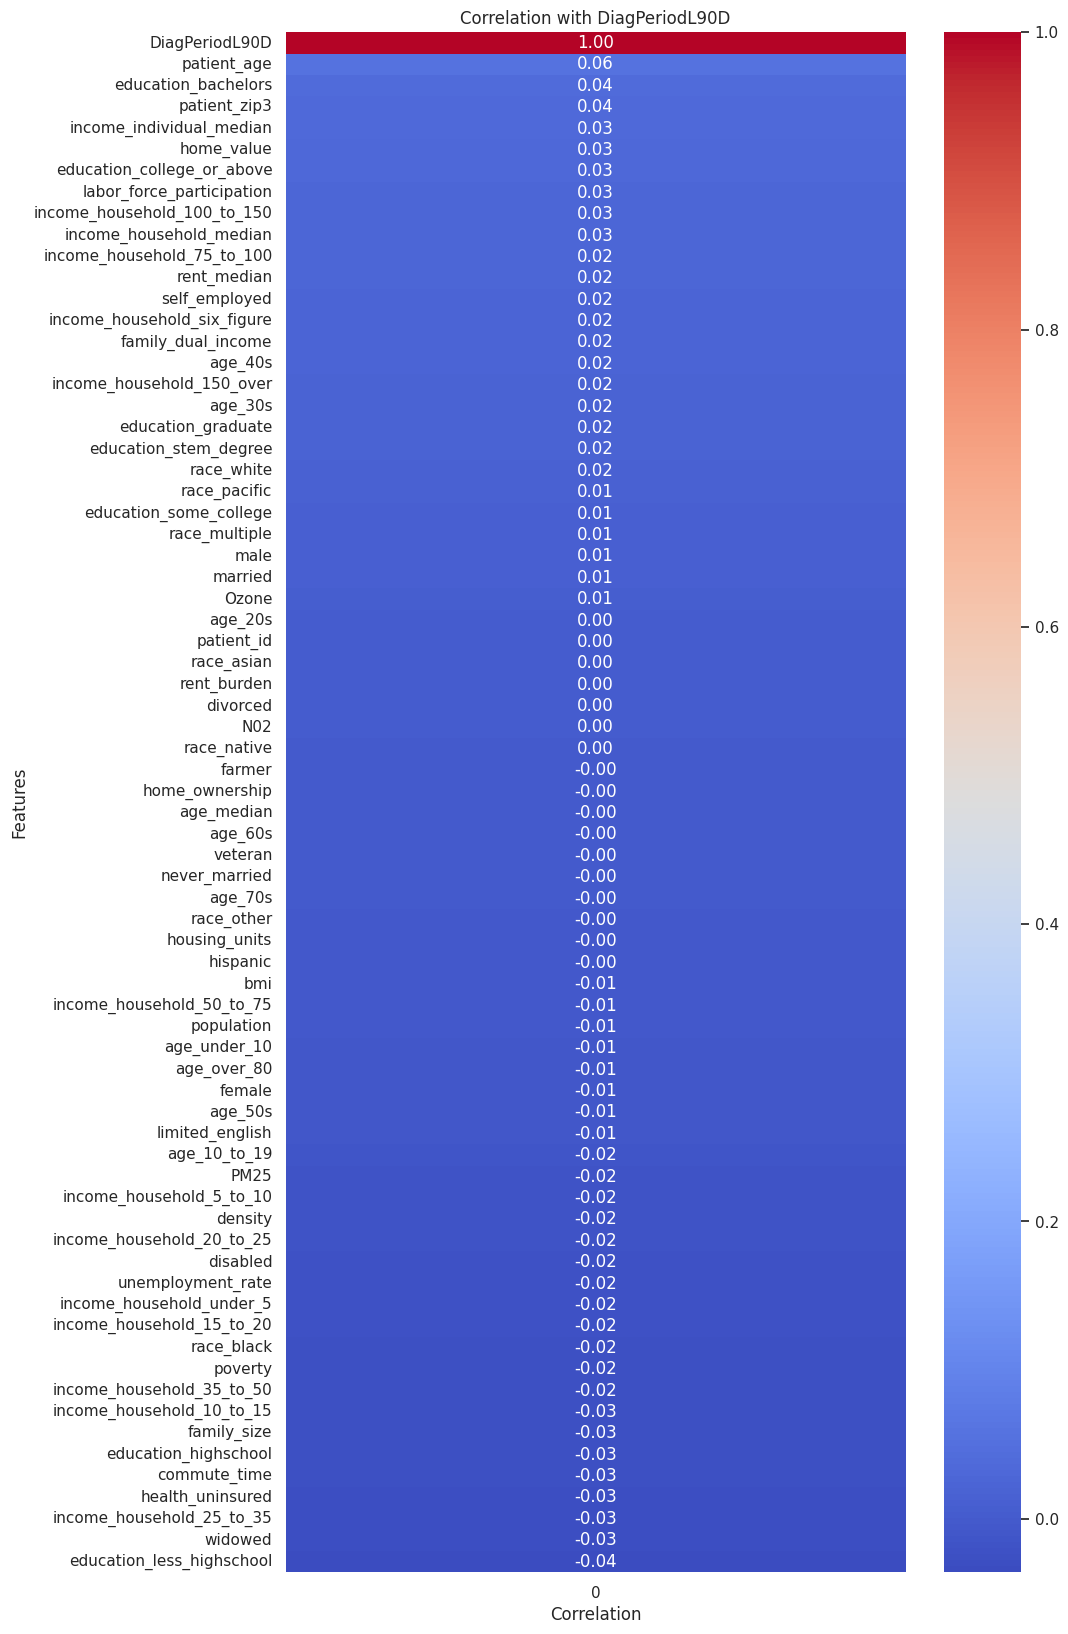

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting numeric columns
numeric_columns = train_data.select_dtypes(include=['number'])

# Calculating correlation matrix
correlation_matrix = numeric_columns.corrwith(train_data['DiagPeriodL90D'])

# Sorting correlation values in descending order
correlation_matrix = correlation_matrix.sort_values(ascending=False)

# Clearing the previous figure
plt.clf()

# Plotting correlation values
plt.figure(figsize=(10, 20))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation with DiagPeriodL90D')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()


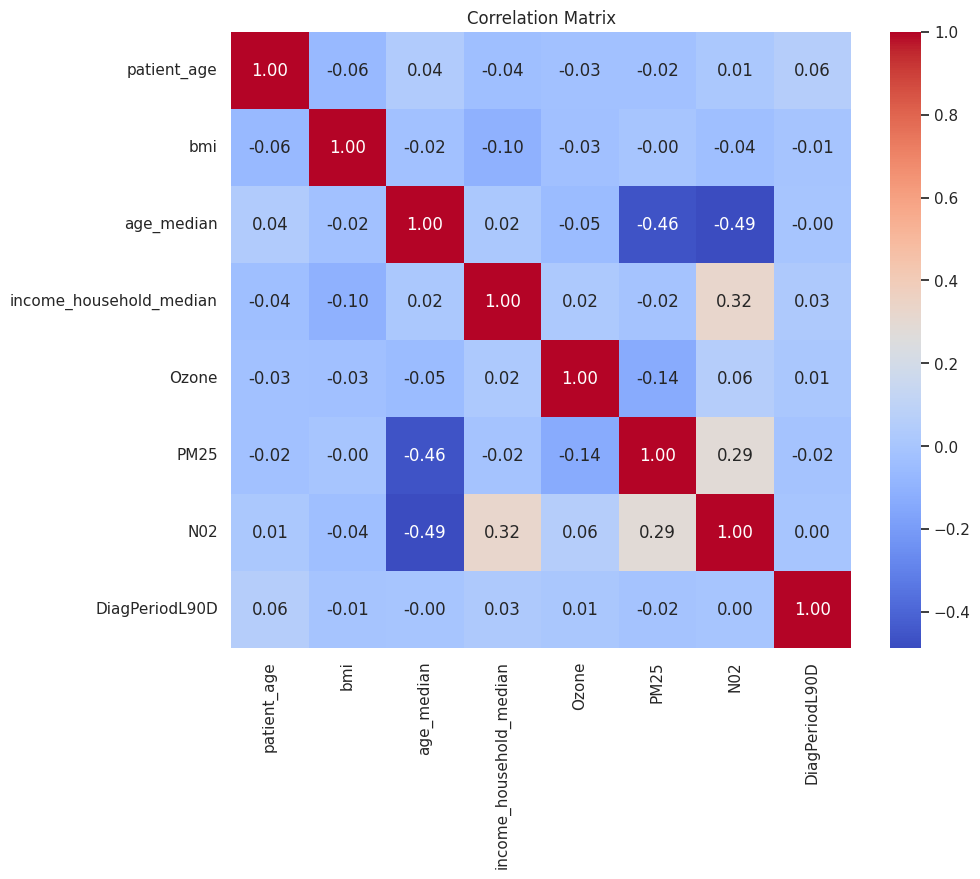

In [41]:
correlation_matrix = train_data[['patient_age', 'bmi', 'age_median', 'income_household_median', 'Ozone', 'PM25', 'N02', 'DiagPeriodL90D']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')

plt.show()

In [42]:
# Geospatial Analysis using Plotly
fig = px.scatter_geo(train_data, locations="patient_state", locationmode="USA-states",
                     color="DiagPeriodL90D", hover_name="patient_state",
                     title="DiagPeriodL90D by State")
fig.show()

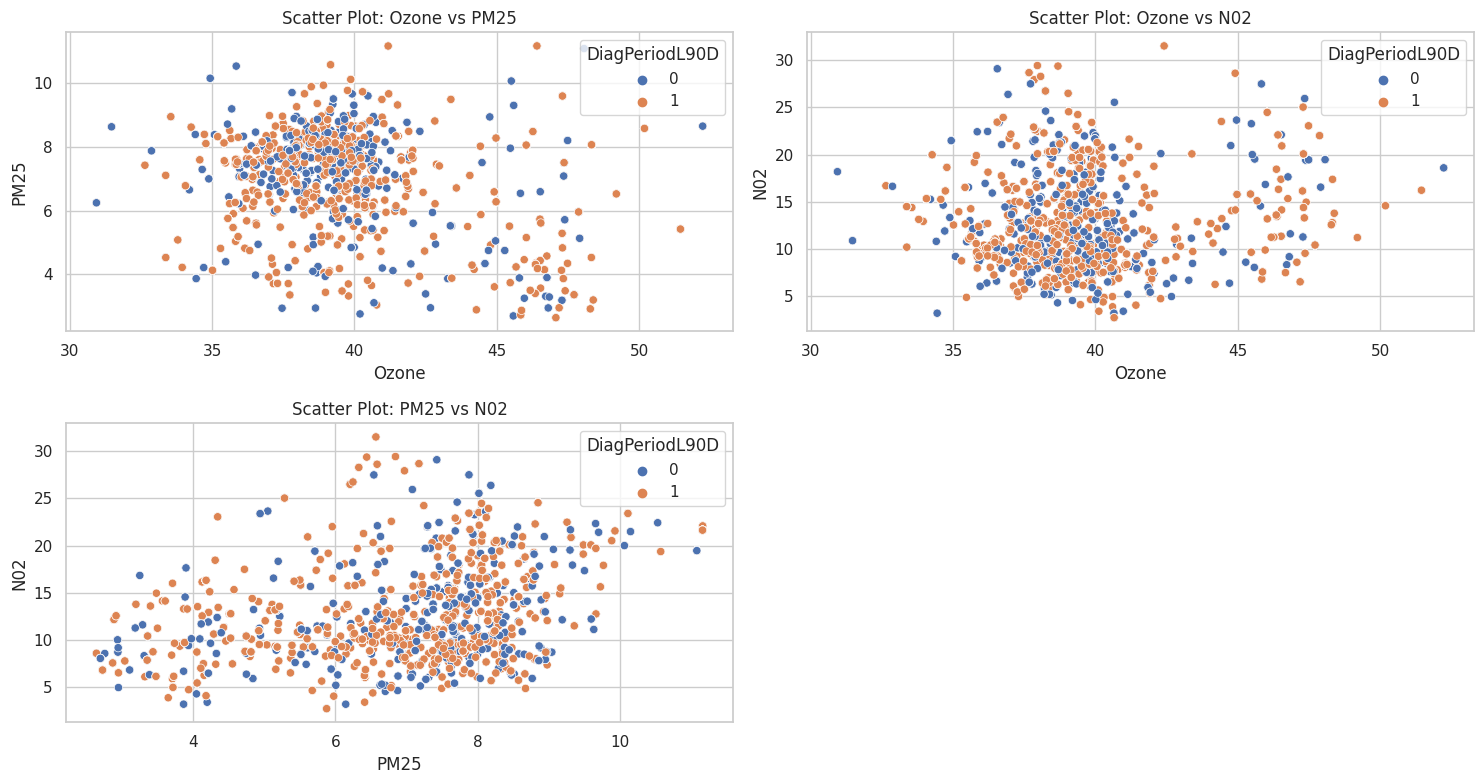

Text(0.5, 1.0, 'Scatter Plot: Age vs Income vs DiagPeriodL90D')

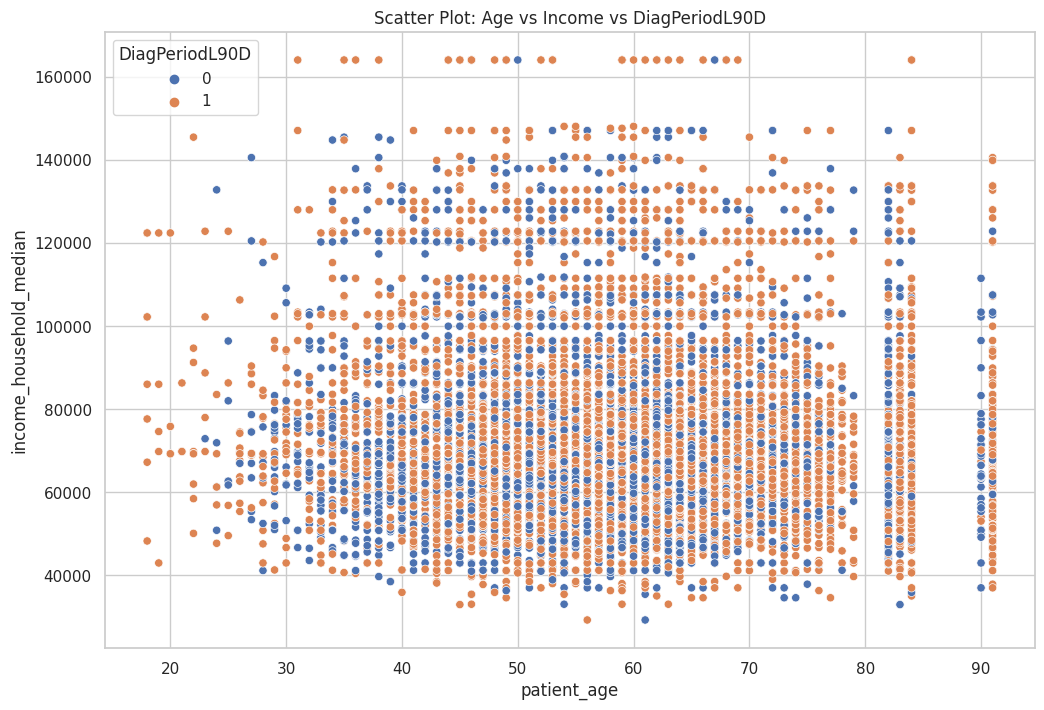

In [43]:
# Toxic Air Quality Analysis
plt.figure(figsize=(15, 8))

# Scatter plots for toxic air quality variables
plt.subplot(2, 2, 1)
sns.scatterplot(x='Ozone', y='PM25', hue='DiagPeriodL90D', data=train_data)
plt.title('Scatter Plot: Ozone vs PM25')

plt.subplot(2, 2, 2)
sns.scatterplot(x='Ozone', y='N02', hue='DiagPeriodL90D', data=train_data)
plt.title('Scatter Plot: Ozone vs N02')

plt.subplot(2, 2, 3)
sns.scatterplot(x='PM25', y='N02', hue='DiagPeriodL90D', data=train_data)
plt.title('Scatter Plot: PM25 vs N02')

plt.tight_layout()
plt.show()

# Multivariate Analysis
# Assuming you want to explore interactions between 'patient_age', 'income_household_median', and 'DiagPeriodL90D'
plt.figure(figsize=(12, 8))
sns.scatterplot(x='patient_age', y='income_household_median', hue='DiagPeriodL90D', data=train_data)
plt.title('Scatter Plot: Age vs Income vs DiagPeriodL90D')

# **Data Preprocessing**

In [14]:
missing_values = train_data.isnull().sum()

# Filter columns with missing values
columns_with_missing_values = missing_values[missing_values > 0].index

# Display the columns with missing values and their corresponding counts
print("Columns with missing values:")
print(missing_values[columns_with_missing_values])

Columns with missing values:
patient_race                         6385
payer_type                           1803
patient_state                          51
bmi                                  8965
metastatic_first_novel_treatment    12882
                                    ...  
health_uninsured                        1
veteran                                 1
Ozone                                  29
PM25                                   29
N02                                    29
Length: 75, dtype: int64


In [15]:
missing_values = test_data.isnull().sum()

# Filter columns with missing values
columns_with_missing_values = missing_values[missing_values > 0].index

# Display the columns with missing values and their corresponding counts
print("Columns with missing values:")
print(missing_values[columns_with_missing_values])

Columns with missing values:
patient_race                             2901
payer_type                                760
patient_state                              21
bmi                                      4015
metastatic_first_novel_treatment         5781
metastatic_first_novel_treatment_type    5781
Region                                     21
Division                                   21
family_size                                 1
family_dual_income                          1
income_household_median                     1
income_household_under_5                    1
income_household_5_to_10                    1
income_household_10_to_15                   1
income_household_15_to_20                   1
income_household_20_to_25                   1
income_household_25_to_35                   1
income_household_35_to_50                   1
income_household_50_to_75                   1
income_household_75_to_100                  1
income_household_100_to_150                 1
incom

In [16]:
train_data.columns

Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'patient_age', 'patient_gender', 'bmi',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division',
       'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'in

In [69]:
# #Dropping high nulls columns
# for column in train_data.columns:
#     null_count = train_data[column].isnull().sum()
#     percent_nulls = (null_count / train_data.shape[0]) * 100
#     if percent_nulls > 1:
#         train_data.drop(columns = column,axis = 1,inplace=True)
#         test_data.drop(columns = column,axis = 1,inplace=True)

In [17]:
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns
numerical_cols = train_data.select_dtypes(include=['float64', 'int64']).columns


# Print columns to verify their names
print("Columns in DataFrame:", train_data.columns)
print("Categorical Columns:", categorical_cols)

Columns in DataFrame: Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'patient_age', 'patient_gender', 'bmi',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division',
       'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_hous

In [18]:
# Impute categorical columns using mode
for col in categorical_cols:
    if col != 'DiagPeriodL90D':
        mode = train_data[col].mode()[0]
        train_data[col].fillna(mode, inplace=True)
        test_data[col].fillna(mode, inplace=True)

# Impute numerical columns using mean
for col in numerical_cols:
    if col != 'DiagPeriodL90D':
        median = train_data[col].median()
        train_data[col].fillna(median, inplace=True)
        test_data[col].fillna(median, inplace=True)

In [19]:
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns

le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_cols:
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

In [20]:
train_data

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,4,1,4,924,84,0,28.19,48,42,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,4,0,4,928,62,0,28.49,29,12,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,4,0,43,760,43,0,38.09,18,23,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,4,0,4,926,45,0,28.19,22,4,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,4,0,13,836,55,0,28.19,7,18,...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12901,674178,4,0,34,436,50,0,32.11,29,12,...,17.400000,23.600000,0.864706,19.841176,6.300000,6.247059,38.753055,8.068682,21.140731,1
12902,452909,4,0,4,945,50,0,28.19,47,44,...,11.243210,7.837037,5.411250,34.700000,3.845679,5.671605,36.469947,6.265266,10.728732,1
12903,357486,4,0,4,926,61,0,29.24,47,44,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,1
12904,935417,4,0,33,112,37,0,31.00,7,18,...,10.194737,18.642105,14.173684,42.502632,6.392105,1.755263,37.722740,7.879795,27.496367,0


In [64]:
cols = ['breast_cancer_diagnosis_code','metastatic_cancer_diagnosis_code','patient_race','patient_age','payer_type',
        'patient_state','breast_cancer_diagnosis_desc']

In [63]:
from catboost import CatBoostClassifier, Pool

# Initialize CatBoostClassifier with your chosen hyperparameters
model = CatBoostClassifier(**params)

# Find the indices of categorical features
categorical_features_names = ['patient_race', 'payer_type', 'patient_state', 'patient_gender',
                               'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
                               'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
                               'metastatic_first_novel_treatment_type', 'Region', 'Division']

# Map column names to their corresponding indices
categorical_features_indices = [train.columns.get_loc(col) for col in categorical_features_names]

# Create a CatBoost Pool object
train_pool = Pool(data=train, label=target, cat_features=categorical_features_indices)

# Fit the model on the data
model.fit(train_pool)

# Get feature importance scores
feature_importance = model.get_feature_importance(train_pool)

# Map feature importance scores to feature names
feature_names = train.columns
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Filter feature importance dictionary to include only categorical features
categorical_feature_importance = {feature: importance for feature, importance in feature_importance_dict.items() if feature in categorical_features_names}

# Sort categorical feature importance dictionary by importance score
sorted_categorical_feature_importance = dict(sorted(categorical_feature_importance.items(), key=lambda x: x[1], reverse=True))

# Print feature importance scores for categorical features
for feature, importance in sorted_categorical_feature_importance.items():
    print(f"{feature}: {importance}")


breast_cancer_diagnosis_code: 56.67876380085149
metastatic_cancer_diagnosis_code: 2.300321669572595
payer_type: 0.5501179892443975
patient_race: 0.46862093232592344
breast_cancer_diagnosis_desc: 0.3995329641292991
patient_state: 0.21927411422118845
Division: 0.09783681485265669
Region: 0.06890405077321454
metastatic_first_novel_treatment: 0.0443504361405221
patient_gender: 0.0
metastatic_first_novel_treatment_type: 0.0


In [ ]:
# breast_cancer_diagnosis_code: 56.67876380085149
# metastatic_cancer_diagnosis_code: 2.300321669572595
# payer_type: 0.5501179892443975
# patient_race: 0.46862093232592344
# breast_cancer_diagnosis_desc: 0.3995329641292991
# patient_state: 0.21927411422118845

In [61]:
train = train_data.drop(columns=['DiagPeriodL90D'], axis=1)
target = train_data['DiagPeriodL90D']

In [65]:
train = train_data[cols+['DiagPeriodL90D']].drop(columns=['DiagPeriodL90D'], axis=1)
target = train_data['DiagPeriodL90D']

In [66]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [67]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
    
    'depth':7,
    'random_state': 42,
    'eval_metric': 'AUC',
    'verbose': False,
    'loss_function': 'Logloss',
    'learning_rate':0.3,
    'iterations':100
}


auc_scores = []
test_preds = []
for train_idx, test_idx in cv.split(train, target):
    X_train, X_test = train.iloc[train_idx], train.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
    
    model = CatBoostClassifier(**params)
    
    model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)
    
    preds = model.predict_proba(X_test)[:, 1]
    preds_test = model.predict_proba(test_data[cols])[:, 1]
    test_preds.append(preds_test)
   
    auc_score = roc_auc_score(y_test, preds)
    auc_scores.append(auc_score)
    print(f"AUC Score: {auc_score}")

print(f"Ortalama AUC Skoru: {np.mean(auc_scores)}")
print(pd.DataFrame([1 if prob >= 0.5 else 0 for prob in np.mean(test_preds,axis=0)], columns=['test_preds'])['test_preds'].value_counts())

AUC Score: 0.8149804302780692
AUC Score: 0.8098552010591358
AUC Score: 0.7989133357404605
AUC Score: 0.8084150860291877
AUC Score: 0.8056760186117022
Ortalama AUC Skoru: 0.8075680143437112
test_preds
1    4343
0    1449
Name: count, dtype: int64


In [68]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform, randint

# # Define the parameter grid for Random Search
# param_distributions = {
#     'depth': randint(2, 10),
#     'l2_leaf_reg': uniform(0.1, 10),  
#     'border_count': [32, 64, 128],  
#     'iterations': [100, 500, 1000],  
#     'learning_rate': uniform(0.01, 0.3),  
#     'loss_function': ['Logloss', 'CrossEntropy'],
#     'eval_metric': ['AUC', 'Accuracy'],
#     'bagging_temperature': uniform(0, 1),
#     'min_data_in_leaf': randint(1, 20),
#     'max_leaves': randint(2, 32),
#     'subsample': uniform(0.5, 0.5),
# }

# # Initialize CatBoostClassifier
# model = CatBoostClassifier(random_state=42, verbose=False)

# # Perform Randomized Search with cross-validation
# random_search = RandomizedSearchCV(model, param_distributions, n_iter=50, cv=cv, scoring='roc_auc', random_state=42)
# random_search.fit(train, target)

# # Get the best hyperparameters
# best_params = random_search.best_params_
# print("Best Hyperparameters:", best_params)

# # Evaluate the model with best hyperparameters on the test set
# best_model = random_search.best_estimator_
# test_preds = best_model.predict_proba(test_data[cols])[:, 1]


In [69]:
submission = pd.read_csv('/kaggle/input/widsdatathon2024-challenge1/sample_submission.csv')
submission['DiagPeriodL90D'] = np.mean(test_preds,axis=0)
submission.to_csv('submission.csv',index=False)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=0.2, random_state=42)

In [ ]:
# logreg_model = LogisticRegression()
# logreg_model.fit(X_train, y_train)

# # Use RFE for feature selection
# num_features_to_select = 28
# rfe = RFE(logreg_model, n_features_to_select=num_features_to_select)
# fit = rfe.fit(X_train, y_train)

# # Get selected feature names and their rankings
# selected_feature_names = X_train.columns[fit.support_]

# X_train_selected = X_train[selected_feature_names]
# X_val_selected = X_val[selected_feature_names]
# X_test_selected = test_data[selected_feature_names]

In [ ]:
X_train[X_train.select_dtypes(['number']).columns] = X_train[X_train.select_dtypes(['number']).columns].astype(str)

In [ ]:
X_val[X_val.select_dtypes(['number']).columns] = X_val[X_val.select_dtypes(['number']).columns].astype(str)

In [ ]:
test_data[test_data.select_dtypes(['number']).columns] = test_data[test_data.select_dtypes(['number']).columns].astype(str)

In [ ]:
# Create CatBoost pools for training, validation and testing data
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

test_pool_catboost = Pool(test_data)

In [ ]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
# ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# # Modify the ColumnTransformer to use OrdinalEncoder
# multicolumn_prep = ColumnTransformer([
#     ('encode', ordinal_encoder, categorical_cols_selected),
# ], remainder='passthrough')

In [ ]:
# #lgb library
# import lightgbm as lgb
# from lightgbm import LGBMClassifier
# # #LGBM Best parameters:  {'max_depth': 7, 'min_child_samples': 19, 'learning_rate': 0.013570653703644641, 'n_estimators': 425, 'subsample': 0.3220447078654888, 'colsample_bytree': 0.6332250329962271, 'reg_alpha': 0.020790829521639388, 'reg_lambda': 0.8238668916252945}
# lgbm_params_optuna =  {'max_depth': 7, 
#                        'min_child_samples': 19, 
#                        'learning_rate': 0.013570653703644641, 
#                        'n_estimators': 425, 
#                        'subsample': 0.3220447078654888, 
#                        'colsample_bytree': 0.6332250329962271, 
#                        'reg_alpha': 0.020790829521639388, 
#                        'reg_lambda': 0.8238668916252945}
    
# # lgbm model
# lgbm_model = LGBMClassifier(**lgbm_params_optuna)


In [ ]:
# Assuming you have a RandomForestClassifier named 'rf_model'
model2 = CatBoostClassifier(iterations=2000, verbose=200, learning_rate=0.06)
model2.fit(train_pool, eval_set=val_pool, plot=True)

xgb_model = XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=6)
xgb_model.fit(X_train, y_train)

logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

ensemble_model = VotingClassifier(
    estimators=[
        ('catboost', model2),
#         ('logreg', logreg_model),
# #         ('xgboost', xgb_model),
#         ('lgbm', lgbm_model)
    ],
    voting='hard'  # 'hard' for majority voting, 'soft' for weighted voting
)

ensemble_pipeline = Pipeline([
    ('preprocessor', multicolumn_prep),
    ('model', ensemble_model)
])

# pipeline = Pipeline([
#     ('preprocessor', multicolumn_prep),
#     ('model', model2)
# ])

# Fit the pipeline on the training data
ensemble_pipeline.fit(X_train_selected, y_train)

# Make predictions on the validation set
predictions_ensemble = ensemble_pipeline.predict(X_val_selected)

# Calculate confusion matrix and display
cm_ensemble = confusion_matrix(y_val, predictions_ensemble)
disp_ensemble = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=['No diag in 90 days', 'diag in 90 days'])
disp_ensemble.plot()
plt.title('Confusion Matrix - Ensemble')
plt.show()

# Evaluate the ensemble model on the testing data
accuracy_ensemble = ensemble_pipeline.score(X_val_selected, y_val)
print(f'Ensemble Model Accuracy: {accuracy_ensemble}')


In [ ]:
def score_model(model, label):
    
    print('model: {}'.format(label))
    X = train.copy()
    y = target
              
    skf = StratifiedKFold(n_splits=5,random_state=SEED, shuffle=True)
    
    val_predictions = np.zeros(len(train))
    score_list = []
    for fold, (trx_idx, val_idx) in enumerate(skf.split(X,y)):
        X_train = X.iloc[trx_idx]
        y_train = y.iloc[trx_idx]
        X_val   = X.iloc[val_idx]
        y_val   = y.iloc[val_idx]
        
        model.fit(X_train,y_train)
        y_pred_train = model.predict_proba(X_train)[:,1]
        y_pred_val   = model.predict_proba(X_val)[:,1]
        auc_train = roc_auc_score(y_train,y_pred_train)
        auc_val   = roc_auc_score(y_val,y_pred_val)
        
        val_predictions[val_idx] = y_pred_val
        score_list.append(auc_val)
        print(f'fold: {fold} - AUC Train: {auc_train} - AUC Val {auc_val}') 

    print(f'AUC MEAN {np.mean(score_list)} - Std: {np.std(score_list)}')  
    
    return score_list, val_predictions

In [ ]:
SEED = 42
params_cat=  {'iterations': 1200, 
               'learning_rate': 0.014380362080961516, 
               'max_depth': 4, 
               'subsample': 0.6913509843171719, 
               'colsample_bylevel': 0.7399357734465091, 
               'min_data_in_leaf': 74,
               'logging_level': 'Silent'}
params_lgb= {'learning_rate': 0.0015880317763720944,
             'subsample': 0.6710494933148675, 
             'colsample_bytree': 0.7929648706646588, 
             'num_leaves': 29,
             'verbose':-1}
params_xbg = {'learning_rate': 0.0010329935862538947, 
              'max_depth': 6, 
              'subsample': 0.5281085467708261, 
              'min_child_weight': 9}

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Assuming `cat_cols` contains the names of categorical columns
# Assuming `num_cols` contains the names of numerical columns

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor_catboost = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create the preprocessing pipeline for CatBoost
preprocess_catboost = Pipeline(steps=[('preprocessor', preprocessor_catboost)])


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Assuming `cat_cols` contains the names of categorical columns
# Assuming `num_cols` contains the names of numerical columns

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor_othermodels = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create the preprocessing pipeline for other models
preprocess_othermodels = Pipeline(steps=[('preprocessor', preprocessor_othermodels)])


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

# Assuming X_train, y_train, X_test, and y_test are defined
# Also, assuming preprocess_catboost, preprocess_othermodels, params_cat, params_lgb, etc. are defined

SEED = 42  # Replace with your desired seed

# Define individual models
catboost_model = make_pipeline(preprocess_catboost, CatBoostClassifier(cat_features=categorical_cols, **params_cat, random_state=SEED))
lgbm_model = make_pipeline(preprocess_othermodels, LGBMClassifier(**params_lgb, random_state=SEED))
rf_model = make_pipeline(preprocess_othermodels, RandomForestClassifier(n_estimators=200, random_state=SEED, min_samples_leaf=92, max_features=1.0))
extratrees_model = make_pipeline(preprocess_othermodels, ExtraTreesClassifier(n_estimators=300, random_state=SEED, min_samples_leaf=46, max_features=1.0))
xgb_model = make_pipeline(preprocess_othermodels, XGBClassifier(**params_xbg, random_state=SEED))

# Create a list of tuples containing model names and their corresponding models
models = [
    ('catBoost', catboost_model),
    ('lgbm', lgbm_model),
    ('RF', rf_model),
    ('Extratrees', extratrees_model),
    ('XGB', xgb_model)
]



# Initialize a VotingClassifier
voting_clf = VotingClassifier(estimators=models, voting='hard')

# Fit the ensemble model on the training data
voting_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = voting_clf.predict(X_val)

# Evaluate the accuracy of the ensemble model
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy on the test set:", accuracy)


In [ ]:
score_list, oof_list= pd.DataFrame(), pd.DataFrame()
models = [          
           ('catBoost',make_pipeline(preprocess_catboost,
                                    CatBoostClassifier(cat_features=cat_cols,
                                                       **params_cat,
                                                       random_state=SEED))),          
           ('lgbm',make_pipeline(preprocess_othermodels,
                                 LGBMClassifier(**params_lgb,
                                                random_state=SEED))),                                
                            
           ('RF',make_pipeline(preprocess_othermodels,
                               RandomForestClassifier(n_estimators=200,
                                                      random_state=SEED,
                                                      min_samples_leaf=92,
                                                      max_features=1.0))),
           ('Extratrees',make_pipeline(preprocess_othermodels,
                                       ExtraTreesClassifier(n_estimators=300,
                                                           random_state=SEED,
                                                           min_samples_leaf=46,
                                                           max_features=1.0))),
           ('XGB',make_pipeline(preprocess_othermodels,
                                 XGBClassifier(**params_xbg,random_state=SEED)))                                        

            
        ]
for label, model in models:
    score_list[label], oof_list[label] = score_model(model,label)

In [ ]:


# Use the trained pipeline to predict on the test data
predictions = ensemble_pipeline.predict(X_test_selected)

test_data.set_index('patient_id', inplace=True)

# Assuming you want to add the predictions back to your test dataset
test_data['DiagPeriodL90D'] = predictions


submission = test_data['DiagPeriodL90D']

# Save the submission to a CSV file
submission.to_csv('submission.csv')
